In [1]:
import torch
from sd_pipeline import StableDiffusion3Pipeline
from sd_processor import JointAttnProcessor2_0
pipe = StableDiffusion3Pipeline.from_pretrained("stabilityai/stable-diffusion-3.5-medium", torch_dtype=torch.bfloat16)
pipe = pipe.to("cuda")

/home/wg25r/miniconda/envs/mochi/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading pipeline components...: 100%|██████████| 9/9 [00:02<00:00,  3.24it/s]


In [2]:
negative_prompt = "there are trees in the image"
pipe.tokenizer.tokenize(negative_prompt)
for block in pipe.transformer.transformer_blocks:
    block.attn.processor = JointAttnProcessor2_0()
    block.attn.processor.neg_prompt_len=len(pipe.tokenizer.tokenize(negative_prompt)) + 1

In [9]:
import os
import random
import shutil
try:
    shutil.rmtree("random_sweeps")
    print("Deleted previous random_sweeps directory")
except: 
    pass
os.makedirs("random_sweeps", exist_ok=True)

# "a beautiful landscape in Canada",
# "a serene at sunset on land",
# "a mountain range",

prompts = [
    "a suburban area in USA",
    "a city park in the evening",
]

for i in range(10):
    af = random.uniform(0.1, 7)
    no = random.uniform(-2, 2)
    gc = random.uniform(3, 7)
    for j, prompt in enumerate(prompts):
        image = pipe(
            prompt=prompt,
            negative_prompt=negative_prompt,
            num_inference_steps=16,
            avoidance_factor=af,
            negative_offset=no,
            guidance_scale=gc,
            generator=torch.manual_seed(42), 
        ).images[0] 
        image.save(f"random_sweeps/sweep_{i}_{j}.png")
        print(f"Saved random_sweep/sweep_{i}_{j}.png with af={af:.2f}, no={no:.2f}, gc={gc:.2f}")

Deleted previous random_sweeps directory


100%|██████████| 16/16 [00:07<00:00,  2.05it/s]


Saved random_sweep/sweep_0_0.png with af=1.16, no=-0.55, gc=5.30


100%|██████████| 16/16 [00:07<00:00,  2.03it/s]


Saved random_sweep/sweep_0_1.png with af=1.16, no=-0.55, gc=5.30


100%|██████████| 16/16 [00:07<00:00,  2.04it/s]


Saved random_sweep/sweep_1_0.png with af=4.47, no=1.93, gc=3.01


100%|██████████| 16/16 [00:07<00:00,  2.03it/s]


Saved random_sweep/sweep_1_1.png with af=4.47, no=1.93, gc=3.01


100%|██████████| 16/16 [00:07<00:00,  2.02it/s]


Saved random_sweep/sweep_2_0.png with af=0.41, no=1.83, gc=6.85


100%|██████████| 16/16 [00:07<00:00,  2.02it/s]


Saved random_sweep/sweep_2_1.png with af=0.41, no=1.83, gc=6.85


100%|██████████| 16/16 [00:07<00:00,  2.01it/s]


Saved random_sweep/sweep_3_0.png with af=0.59, no=-0.99, gc=4.37


100%|██████████| 16/16 [00:08<00:00,  2.00it/s]


Saved random_sweep/sweep_3_1.png with af=0.59, no=-0.99, gc=4.37


100%|██████████| 16/16 [00:08<00:00,  1.99it/s]


Saved random_sweep/sweep_4_0.png with af=1.09, no=-0.37, gc=3.30


100%|██████████| 16/16 [00:08<00:00,  1.98it/s]


Saved random_sweep/sweep_4_1.png with af=1.09, no=-0.37, gc=3.30


100%|██████████| 16/16 [00:08<00:00,  1.98it/s]


Saved random_sweep/sweep_5_0.png with af=4.55, no=0.33, gc=3.19


100%|██████████| 16/16 [00:08<00:00,  1.98it/s]


Saved random_sweep/sweep_5_1.png with af=4.55, no=0.33, gc=3.19


100%|██████████| 16/16 [00:08<00:00,  1.98it/s]


Saved random_sweep/sweep_6_0.png with af=1.83, no=0.55, gc=5.87


100%|██████████| 16/16 [00:08<00:00,  1.97it/s]


Saved random_sweep/sweep_6_1.png with af=1.83, no=0.55, gc=5.87


100%|██████████| 16/16 [00:08<00:00,  1.97it/s]


Saved random_sweep/sweep_7_0.png with af=0.25, no=-1.11, gc=3.42


100%|██████████| 16/16 [00:08<00:00,  1.96it/s]


Saved random_sweep/sweep_7_1.png with af=0.25, no=-1.11, gc=3.42


100%|██████████| 16/16 [00:08<00:00,  1.96it/s]


Saved random_sweep/sweep_8_0.png with af=0.87, no=-0.60, gc=3.31


100%|██████████| 16/16 [00:08<00:00,  1.96it/s]


Saved random_sweep/sweep_8_1.png with af=0.87, no=-0.60, gc=3.31


100%|██████████| 16/16 [00:08<00:00,  1.96it/s]


Saved random_sweep/sweep_9_0.png with af=3.52, no=-1.02, gc=6.44


100%|██████████| 16/16 [00:08<00:00,  1.96it/s]


Saved random_sweep/sweep_9_1.png with af=3.52, no=-1.02, gc=6.44


In [7]:
# show all images by concate them
import numpy as np
from PIL import Image
from PIL import ImageDraw

images = []
for j in range(2):
    row = []
    for i in range(10):
        image = Image.open(f"random_sweeps/sweep_{i}_{j}.png")
        row.append(np.array(image))
    
    images.append(np.concatenate(row, axis=1))
image = np.concatenate(images, axis=0)
Image.fromarray(image).save("sweeps.png")

    

100%|██████████| 16/16 [00:08<00:00,  1.97it/s]


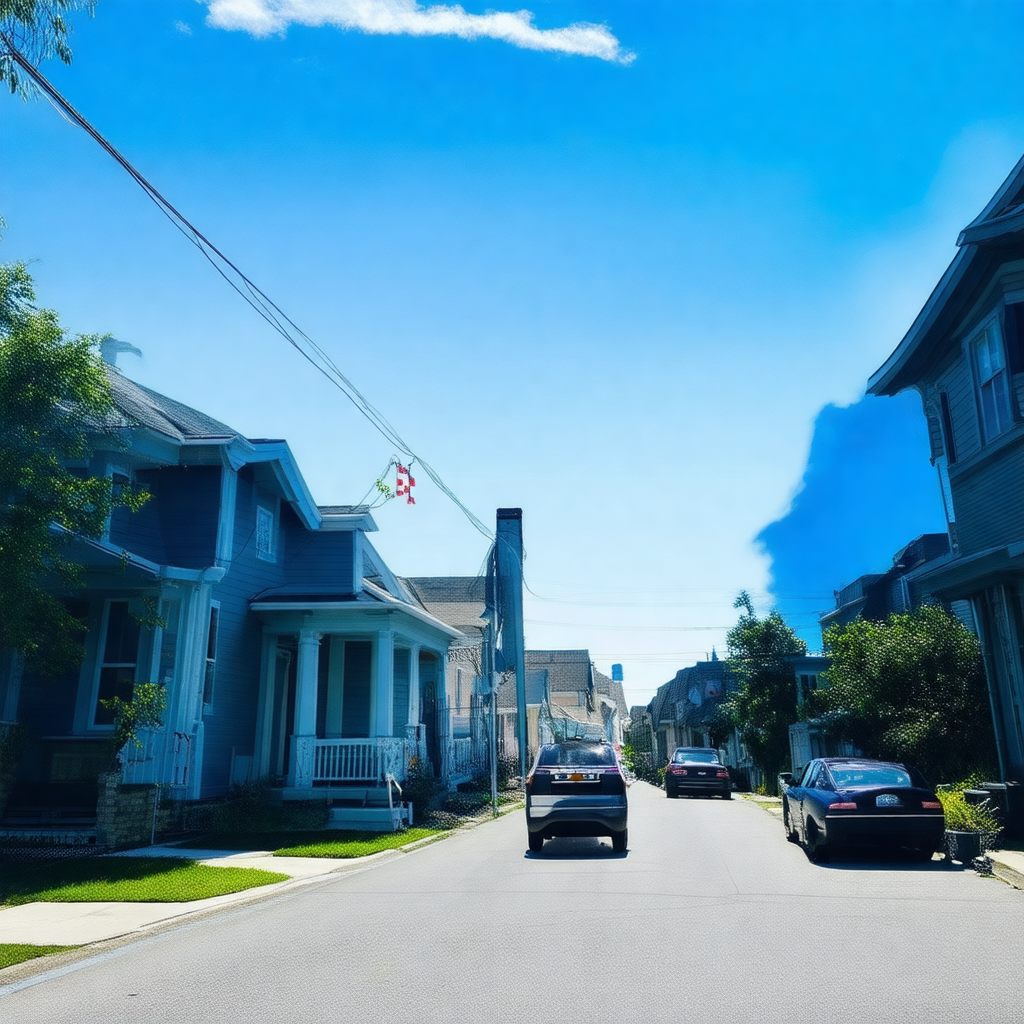

In [5]:
import os
import random
os.makedirs("random_sweeps", exist_ok=True)

negative_prompt = "there are trees in the image"
pipe.tokenizer.tokenize(negative_prompt)
for block in pipe.transformer.transformer_blocks:
    block.attn.processor = JointAttnProcessor2_0()
    block.attn.processor.neg_prompt_len=len(pipe.tokenizer.tokenize(negative_prompt)) + 1


af = 3; no = 0; gc = 8
image = pipe(
    "a US suburban street in the summer",
    negative_prompt=negative_prompt,
    num_inference_steps=16,
    avoidance_factor=af,
    negative_offset=no,
    guidance_scale=gc,
    generator=torch.manual_seed(89), 
).images[0] 
image

In [8]:
torch.stack(pipe.neg_maps)[4].shape

torch.Size([24, 1, 24, 1, 4096])

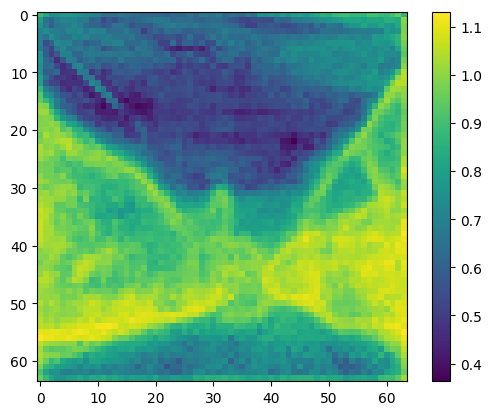

In [6]:
import pylab 
map = torch.tanh(torch.stack(pipe.neg_maps))[4].mean((0,1,2,3)).reshape(64, 64).cpu().float().numpy() * 1.5
pylab.imshow(map) 
pylab.colorbar()